<a href="https://colab.research.google.com/github/LeoisWTT/PHYS3151-Machine-Learning-in-Physics-2023/blob/main/SVM_Fermi_Surface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt  
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

In this notebook, we try to investigate the Hubbard model using SVM and logistic regression, so as to locate the fermi surface.

Hubbard model is the simplest fermionic model, where there are fermions on lattice which can hop to adjcent site. It has the following Hamiltonian.
$$H=-t\mathop{\sum}\limits_{<i,j>\sigma}c_{i\sigma}^\dagger c_{j\sigma}+h.c.$$
The angle bracket ${\langle i,j\rangle}$ suggest that the summation only run over all adjacent pairs of $i$ and $j$, and $\sigma=\uparrow,\downarrow$ indecates the fermion spin being up or down.

Here we take $t$=1.

By doing Fourier transform, we can find the exact eneregy spectrum (dispersion relation) of the system. The energy depends on momentum ${\textbf{k}=(k_x,k_y)}$, where $k_x$ and $k_y$ take value from $0$ to $2\pi$.  And the corresponding single particle energy is.
$$\epsilon(\textbf{k})=-2t(\cos k_x+\cos k_y)$$
The dispersion in the Brillouin zone is shown as follow.

<ipython-input-29-e4517fb0072c>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


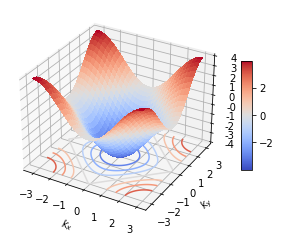

In [29]:
fig = plt.figure()
ax = fig.gca(projection='3d')
# Make data.
X = np.arange(-np.pi, np.pi, 0.1)
Y = np.arange(-np.pi, np.pi, 0.1)

X, Y = np.meshgrid(X, Y)
Z = -2*(np.cos(X)+np.cos(Y))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
cset = ax.contour(X, Y, Z, zdir='z', offset=-4, cmap=cm.coolwarm)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlabel('$k_x$')
ax.set_ylabel('$k_y$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

Fermions subject to the Pauli exclusion principle, which states that no two indentical fermions can be in the same state. As a result, in low temperature limit, fermions will fill up the energy spectrum from low to high.

We know from the fourier transform that the number of $k$ points in the Brillouin zone is the same as the number of site in real space. Each $k$ point can take up 2 fermions, one in each spin orientation. As a result, we can fill up to $2N$ fermion in the system, where $N$ is the number of site.

The highest single particle energy is called the fermi energy $\epsilon_f$, and the equienergy surface (or simply a curve in 2-dimension case) where ${\epsilon(\textbf{k})=\epsilon_f}$ is called the fermi surface.

We first consider the half-filled case, where we fill $N$ fermions in this system, which is the same as setting chemical potential $\mu=0$. In this case, the fermi surface is just the square we see on the x-y plane in the above plot.

Also, we only consider the first quadrant ($k_x,k_y\gt0$), and we can get the rest by symmetry.

# SVM

In [30]:
N=50
mu=0    #chemical potential

In [31]:
kx_list=np.pi*np.array([np.random.random() for i in range(N)]).reshape((N,1))
ky_list=np.pi*np.array([np.random.random() for i in range(N)]).reshape((N,1))

In [32]:
E=[float(-2*(np.cos(kx_list[i])+np.cos(ky_list[i]))) for i in range(N)]
#print(E)
occupancy=[E[i]<=mu for i in range(N)]
#print(occupancy)

In [33]:
def hinge(X,y,theta):                        #for maximum-margin classification
    pred = 1 - np.multiply(y,(X.dot(theta)))
    loss = np.maximum(np.zeros(pred.shape),pred)
    hinge = np.sum(loss)
    return hinge

def computeCost(X,y,theta,reg=0):
    m = float(len(y))
    theta2 = np.square(theta)
    cost = (reg/(2*m)) * np.sum(theta2) + (1/m) * hinge(X,y,theta)
    return cost

In [34]:
def check(X,y,theta):
    X_b = np.c_[np.ones((len(X),1)),X]
    
    fx = np.multiply(y,(X_b.dot(theta)))
    
    check = np.less(fx,np.ones(fx.shape))
    
    check = np.where(check==True,1,0)
    
    return check

def subgradient_descent(X,y,theta,iterations=100,reg=0):
    '''
    X    = Matrix of X
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    alpha 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = float(y.shape[0])
    
    X_b = np.c_[np.ones((len(X),1)),X]
    
    cost_history = np.zeros(iterations)
    
    theta_history = np.zeros((iterations,X_b.shape[1]))
    
    for it in range(iterations):
        alpha = 1/(reg*(it+1))
        #print(X_b.shape)
        #print(X_b.dot(theta).shape)
        #print(np.multiply(y,(X_b.dot(theta))).shape)
        #print(y.shape)
        theta = theta + alpha*((np.multiply(check(X,y,theta),y)).T.dot(X_b)).T
        theta[1:] = theta[1:] - alpha*reg*theta[1:]
        theta_history[it,:] = theta.T
        cost_history[it]  = computeCost(X_b,y,theta,reg)
        
    return theta, cost_history, theta_history

In [35]:
y = np.where(occupancy,1.,-1.).reshape((N,1))
#print(y)

In [36]:
X=np.array([kx_list[:,0], ky_list[:,0]])
X=X.T
X_b = np.c_[np.ones((N,1)),X]
n=X_b.shape[1]
theta = np.random.random((n,1))

In [37]:
reg = 0.0001
n_iter = 200000
theta,cost_history,theta_history = subgradient_descent(X,y,theta,n_iter,reg)
print(theta)
print('Final Cost is :', cost_history[-1])

[[ 7371.58166617]
 [-2332.404076  ]
 [-2261.01019421]]
Final Cost is : 64.8924921330452


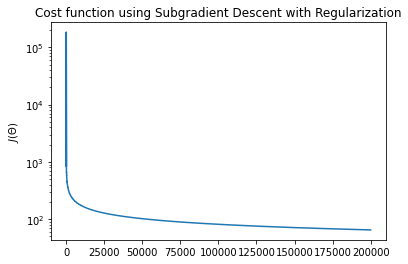

In [38]:
import matplotlib.pyplot as plt
plt.plot(cost_history)
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Subgradient Descent with Regularization")
plt.yscale('log')
plt.show()

(0.0, 3.141592653589793)

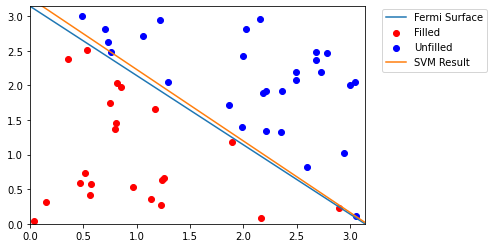

In [39]:
x_plot=np.array([0, np.pi])
plt.plot(x_plot,-x_plot+np.pi,label='Fermi Surface')
plt.scatter(kx_list[occupancy], ky_list[occupancy], c='r',label='Filled')
plt.scatter(kx_list[np.invert(occupancy)], ky_list[np.invert(occupancy)], c='b',label='Unfilled')
plt.plot(x_plot, (-theta[1]*x_plot-theta[0])/theta[2],label='SVM Result')
plt.legend(loc=(1.05,0.7))
plt.xlim(0,np.pi)
plt.ylim(0,np.pi)

# Logistic Regression

In [40]:
import numpy as np
from scipy.optimize import fmin_tnc


class LogisticRegressionUsingGD:

# Activation function used to map any real value between 0 and 1
    @staticmethod
    def sigmoid(x):  
        return 1 / (1 + np.exp(-x))

# Computes the weighted sum of inputs Similar to Linear Regression
    @staticmethod
    def net_input(theta, x):
        return np.dot(x, theta)

# Calculates the probability that an instance belongs to a particular class
    def probability(self, theta, x):
        return self.sigmoid(self.net_input(theta, x))

# Computes the cost function for all the training samples
    def cost_function(self, theta, x, y):
        m = x.shape[0]
        total_cost = -(1 / m) * np.sum([np.log(self.probability(theta, x[i])) if y[i]==1 else np.log(1-self.probability(theta, x[i])) for i in range(m)])
        return total_cost

# Computes the gradient of the cost function at the point theta
    def gradient(self, theta, x, y):     
        m = x.shape[0]
        return (1 / m) * np.dot(x.T, self.sigmoid(self.net_input(theta, x)) - y)

    def fit(self, x, y, theta):
        opt_weights = fmin_tnc(func=self.cost_function, x0=theta, fprime=self.gradient, args=(x, y.flatten()))
        self.w_ = opt_weights[0]
        return self

    def predict(self, x):
        theta = self.w_[:, np.newaxis]
        return self.probability(theta, x)

    def accuracy(self, x, actual_classes, probab_threshold=0.5):
        predicted_classes = (self.predict(x) >= probab_threshold).astype(int)
        predicted_classes = predicted_classes.flatten()
        accuracy = np.mean(predicted_classes == actual_classes)
        return accuracy * 100

In [41]:
y = np.where(occupancy,1.,0.).reshape((N,1))
y = np.array(y)
#print(y)
theta = np.zeros((X_b.shape[1], 1))

In [42]:
model1 = LogisticRegressionUsingGD()
model1.fit(X_b, y, theta)
accuracy = model1.accuracy(X_b, y.flatten())
parameters = model1.w_
print("The accuracy of the model is {}".format(accuracy))
print("The model parameters got by Gradient descent:")
print(parameters)

The accuracy of the model is 100.0
The model parameters got by Gradient descent:
[1014.17632979 -322.99332166 -322.4987253 ]


(0.0, 3.141592653589793)

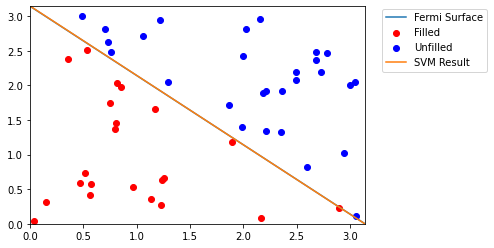

In [43]:
x_plot=np.arange(0, np.pi, 0.01)
y_plot=np.arccos(-mu/2-np.cos(x_plot))
plt.plot(x_plot,-x_plot+np.pi,label='Fermi Surface')
plt.scatter(kx_list[occupancy], ky_list[occupancy], c='r',label='Filled')
plt.scatter(kx_list[np.invert(occupancy)], ky_list[np.invert(occupancy)], c='b',label='Unfilled')
plt.plot(x_plot, (-parameters[1]*x_plot-parameters[0])/parameters[2],label='SVM Result')
plt.legend(loc=(1.05,0.7))
plt.xlim(0,np.pi)
plt.ylim(0,np.pi)

# Away from Half-filled

In [44]:
N=100
mu=-2    #chemical potential

In [45]:
kx_list=np.pi*np.array([np.random.random() for i in range(N)]).reshape((N,1))
ky_list=np.pi*np.array([np.random.random() for i in range(N)]).reshape((N,1))

In [46]:
E=[float(-2*(np.cos(kx_list[i])+np.cos(ky_list[i]))) for i in range(N)]
#print(E)
occupancy=[E[i]<=mu for i in range(N)]
#print(occupancy)

# SVM

In [47]:
y = np.where(occupancy,1.,-1.).reshape((N,1))
#print(y)

Here we also include the second order term of $k_x$ and $k_y$ as features, as we need to approximate curve other than simple straight line.

In [48]:
X=np.array([kx_list[:,0], ky_list[:,0], kx_list[:,0]**2, ky_list[:,0]**2])
X=X.T
X_b = np.c_[np.ones((N,1)),X]
n=X_b.shape[1]
theta = np.random.random((n,1))

In [49]:
reg = 0.0001
n_iter = 200000
theta,cost_history,theta_history = subgradient_descent(X,y,theta,n_iter,reg)
print(theta)
print('Final Cost is :', cost_history[-1])

[[ 414.41144878]
 [ -77.89489092]
 [ -74.79458177]
 [-115.71129062]
 [-105.04794298]]
Final Cost is : 0.10391143273960389


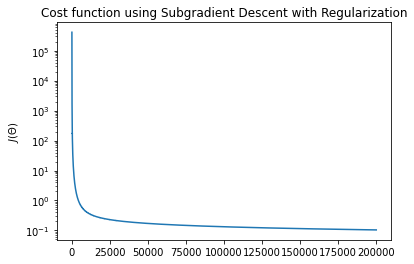

In [50]:
import matplotlib.pyplot as plt
plt.plot(cost_history)
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Subgradient Descent with Regularization")
plt.yscale('log')
plt.show()

<ipython-input-51-519de740bd62>:2: RuntimeWarning: invalid value encountered in arccos
  y_plot=np.arccos(-mu/2-np.cos(x_plot))


(0.0, 3.141592653589793)

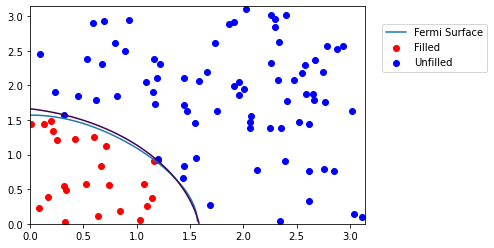

In [51]:
x_plot=np.arange(0, np.pi, 0.01)
y_plot=np.arccos(-mu/2-np.cos(x_plot))
[XX,YY]=np.meshgrid(x_plot,x_plot)
plt.plot(x_plot,y_plot,label='Fermi Surface')
plt.scatter(kx_list[occupancy], ky_list[occupancy], c='r',label='Filled')
plt.scatter(kx_list[np.invert(occupancy)], ky_list[np.invert(occupancy)], c='b',label='Unfilled')
plt.contour(XX,YY, theta[0]+theta[1]*XX+theta[2]*YY+theta[3]*XX**2+theta[4]*YY**2,[0])
plt.legend(loc=(1.05,0.7))
plt.xlim(0,np.pi)
plt.ylim(0,np.pi)

# Logistic Regression

In [52]:
y = np.where(occupancy,1.,0.).reshape((N,1))
y = np.array(y)
#print(y)
theta = np.zeros((X_b.shape[1], 1))

In [53]:
model1 = LogisticRegressionUsingGD()
model1.fit(X_b, y, theta)
accuracy = model1.accuracy(X_b, y.flatten())
parameters = model1.w_
print("The accuracy of the model is {}".format(accuracy))
print("The model parameters got by Gradient descent:")
print(parameters)

The accuracy of the model is 100.0
The model parameters got by Gradient descent:
[ 343.7067377    13.90839222   39.09729226 -187.26760483 -161.39373827]


<ipython-input-40-349e78460cf8>:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


(0.0, 3.141592653589793)

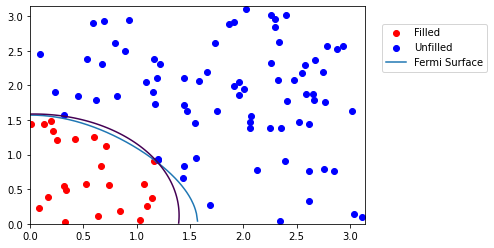

In [54]:
plt.scatter(kx_list[occupancy], ky_list[occupancy], c='r',label='Filled')
plt.scatter(kx_list[np.invert(occupancy)], ky_list[np.invert(occupancy)], c='b',label='Unfilled')
plt.plot(x_plot,y_plot,label='Fermi Surface')
plt.contour(XX,YY, parameters[0]+parameters[1]*XX+parameters[2]*YY+parameters[3]*XX**2+parameters[4]*YY**2,[0])
plt.legend(loc=(1.05,0.7))
plt.xlim(0,np.pi)
plt.ylim(0,np.pi)